# Creates and pickles adversarial noise for the mnist dataset.
The model is trained and saved in another notebook
## Define the model

In [1]:
import tensorflow as tf
import numpy as np
from parana.Model import Model
from parana.Layers import fc_layer
from parana.Layers import softmax_layer
from parana.optimizer import optimizer
from parana.optimizer import adamopt
from parana.parameter_saver import saver
import matplotlib.pyplot as plt
import pickle

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#path = Path where you want to save noise

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot = True)

class this_model(Model):
    
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        self.cost_function = 'quadratic_l2'
        self.logit_cost_function = 'quadratic_l2'
        self.dropout = 0.7
        self.layers = [fc_layer(inputs=inputs + noise,
                               weight_init = 'xavier',
                               size=1500,
                               weight_decay=0.0001, bias_decay=0.0001)]
        self.layers.append(fc_layer(inputs=self.layers[0].activate, 
                               weight_init = 'xavier',
                               size=800, 
                               weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(fc_layer(inputs=self.layers[1].activate, 
                               weight_init = 'xavier',
                               size=400, 
                               weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(softmax_layer(inputs=self.layers[2].activate, 
                                          size=10, 
                                          weight_decay=0.0001, bias_decay=0.0001))
    
X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

# Limit on the intensity/strength of noise
noise_limit = 0.25

# Tensorflow assignments and functions
noise = tf.Variable(tf.zeros([784]), name='x_noise')
set_zero_noise = tf.assign(noise, tf.zeros([784]))
noise_placeholder = tf.placeholder('float', [784], name = 'noise_placeholder')
assign_noise = tf.assign(noise, noise_placeholder)
X_noise = X + noise
X_noise = tf.clip_by_value(X_noise, 0.0, 1.0)
x_noise_clip = tf.assign(noise, tf.clip_by_value(noise, -noise_limit, noise_limit))

mymodel = this_model(X_noise, y)

sess = tf.Session()

#Optimizer for training the noise vector
noise_opt = optimizer(sess, 0.1, mymodel.cost, model =  mymodel, variables_list = noise)

sess.run(tf.global_variables_initializer())

model_saver = saver(mymodel, sess)

C:\Users\Jim\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Load the model

In [6]:
#modelpath = Where you store your model
model_saver.load_parameters('{model.p'.format(path))
print(mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))

Parameters loaded from  c:/users/jim/tensorflowtrials/ANN_98.13%_pruned.p
0.9813


## Pickle the noise

In [7]:
path = 'path'
import pickle
# Loop over noise_opt and pickle each noise file
for adversary_class in range(10):
    for i in range(5000):
        batch = mnist.train.next_batch(250)
        #Set labels to zero then target class to 1
        adv_labels = np.zeros_like(batch[1])
        adv_labels[:, adversary_class] = 1.0
        batch = (batch[0], adv_labels)
        noise_opt.min_step(data = {X:batch[0], y:batch[1]})
        sess.run(x_noise_clip)
    noisevector = sess.run(noise)
    pickle.dump(noisevector, open('{}adv_class_{}_limit_{}.p'.format(path, adversary_class, noise_limit), 'wb'))
    print('Test Accuracy for class {}'.format(adversary_class),mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))
    #reset the noise vector
    sess.run(set_zero_noise)
print('Test Accuracy with no noise',mymodel.accuracy(sess,inputs =  mnist.test.images, labels =  mnist.test.labels))

Test Accuracy for class 0 0.98
Test Accuracy for class 1 0.9785
Test Accuracy for class 2 0.9063
Test Accuracy for class 3 0.9389
Test Accuracy for class 4 0.9277
Test Accuracy for class 5 0.9755
Test Accuracy for class 6 0.976
Test Accuracy for class 7 0.8824
Test Accuracy for class 8 0.976
Test Accuracy for class 9 0.9616
Test Accuracy with no noise 0.9813


# Sanity check

In [5]:
noisevector = sess.run(x_noise)
#print accuracy with noise added
batch = mnist.train.next_batch(250)
train_accuracy = sess.run(mymodel.accuracy, feed_dict = {X:batch[0], y:batch[1]})
print('Accuracy with noise', train_accuracy)
print('Test Accuracy',sess.run(mymodel.accuracy, feed_dict = {X:mnist.test.images, y:mnist.test.labels}))

Accuracy with noise 0.984
Test Accuracy 0.9815


# Look at one of the noise vectors as an image

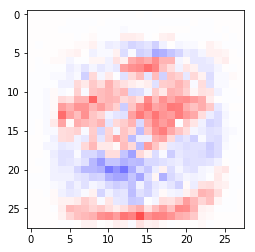

In [4]:
%matplotlib inline
import numpy as np
import pickle
import matplotlib.pyplot as plt
path = 'c:/users/jim/tensorflowtrials/adv_noise/'
#noisevector = pickle.load(open('{}adv_class_2_limit_0.25.p'.format(path), 'rb'))
def plot_noise():
    plt.imshow(np.reshape(noisevector, (28, 28)), interpolation='nearest', cmap='seismic',
               vmin=-1.0, vmax=1.0)
plot_noise()